# Internal setting


In [1]:
import params_molgen
params = params_molgen


In [2]:
for line in open(params.readmefile):
    print (line.rstrip())

excluded unphased variants
excluded multinucleotide variants
minimum mapping quality is 255
samtools view L18098Aligned.sortedByCoord.out.bam | cut -f 5 | sort -nr | uniq -c | head
89282132 255
7706264 3
2162614 1
927020 0


# Code 

In [3]:
import numpy as np
import vcf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import pysam


def count_reads(chrm, view_start, view_end, samfiles, vcf_reader):
    mother = []
    father = []
    coordinates = []
    mother_is_ref = []
    replicate = []

    for Record in vcf_reader.fetch(chrm, view_start, view_end):  # doctest: +SKIP
        genotype = Record.genotype(individual_name)['GT']

        # not phased or homozygous
        if not ("|" == genotype[1]) or genotype[0]==genotype[2]:
            continue

        # multi nucleotide polymorphism
        one_nc_snp = True
        for var in Record.ALT:
            if len(var) > 1:
                one_nc_snp = False
        if len(Record.REF) > 1 or not one_nc_snp:
            continue


        snp = Record.POS
        mp_cnt = {}

        bo_first = True
        for rep, samfile in zip(range(len(samfiles)),samfiles):
            for pileupcolumn in samfile.pileup(chrm, snp - 1, snp):
                if bo_first:
                    bo_first = False
                    #print(Record.CHROM, Record.POS, Record.ID, Record.REF, Record.ALT, Record.genotype(individual_name)['GT'])
                if pileupcolumn.pos == snp - 1:
                    for pileupread in pileupcolumn.pileups:
                        if not pileupread.is_del and pileupread.alignment.mapping_quality >= 255:
                            mp_cnt[pileupread.alignment.query_sequence[pileupread.query_position]] = mp_cnt.get(
                                pileupread.alignment.query_sequence[pileupread.query_position], 0) + 1
            
            # mapping quality is lower 
            if len(mp_cnt) == 0:
                continue
            
            vars = [Record.REF] + [str(v) for v in Record.ALT]
            coordinates += [Record.POS]
            replicate += [rep]
            
            #print (mp_cnt,vars)
            mothers_allele = vars[int(genotype[0])]
            fathers_allele = vars[int(genotype[2])]
            
            if mothers_allele in mp_cnt:
                mother += [mp_cnt[mothers_allele]]
            else:
                mother += [0]

            if fathers_allele in mp_cnt:
                father += [mp_cnt[fathers_allele]]
            else:
                father += [0]
            #print (mother[-1],father[-1])
            
            if genotype[0] == "0":
                mother_is_ref += [True]
            else:
                mother_is_ref += [False]


    m = np.array(mother, dtype=np.float)
    f = np.array(father, dtype=np.float)
    c = np.array(coordinates, dtype=np.int)
    ref = np.array(mother_is_ref, dtype=np.bool)
    rep = np.array(replicate,dtype=np.int)
    return m, f, c, ref,rep





In [4]:

bams = [pysam.AlignmentFile(params.path + f) for f in params.RNAseqbams]
vcf_reader = vcf.Reader(open(params.vcf_file))
individual_name = params.individual_name
interval_string = params.interval_string
interval_string = params.interval_string
open_left_region = params.open_left_region
open_right_region = params.open_right_region



In [5]:
df_main = pd.DataFrame({'Mother':[], 'Father':[],'Coordinate':[],'MotherIsRef':[], 'Rep': []})

for inx_replicate in range(len(bams)):
    interval = interval_string.replace(",",'')
    chrm = interval.split(":")[0]
    sv_start = int(interval.split(":")[1].split("-")[0])
    sv_end = int(interval.split(":")[1].split("-")[1])
    view_start = sv_start - open_left_region
    view_end = sv_end + open_right_region
    m,f,c,ref,rep= count_reads(chrm,view_start,view_end,bams,vcf_reader)
    d = {'Mother':m, 'Father':f,'Coordinate':c,'MotherIsRef':ref, 'Rep': rep}
    df_main = df_main.append(pd.DataFrame(d))

df_main['Ratio'] = df_main['Mother'] / df_main['Father']
print ('done')

done


In [6]:
df_main.head()

,Coordinate,Father,Mother,MotherIsRef,Rep,Ratio
0,153073319.0,0.0,2.0,0.0,0.0,inf
1,153073319.0,0.0,2.0,0.0,1.0,inf
2,153073319.0,0.0,2.0,0.0,2.0,inf
3,153088219.0,0.0,1.0,0.0,1.0,inf
4,153088219.0,0.0,3.0,0.0,2.0,inf


/confidential/FamilyR13/CODE/Anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 300)

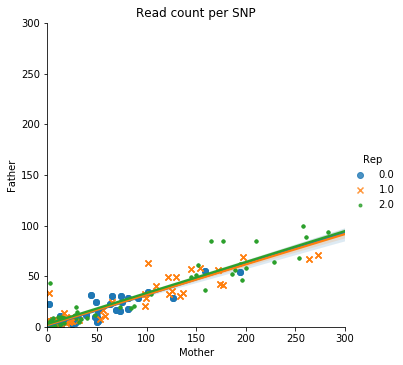

In [7]:
df_main_removeInf = df_main[(df_main['Mother'] != 0.0) & (df_main['Father'] != 0.0)]
sns.lmplot(x='Mother',y='Father',hue='Rep',data=df_main_removeInf,markers=['o','x','.'])
ax = plt.gca()
ax.set_title("Read count per SNP")
ax.set_xlim(0,300)
ax.set_ylim(0,300)

In [8]:
df_main_removeInf.head()


,Coordinate,Father,Mother,MotherIsRef,Rep,Ratio
31,153195393.0,4.0,28.0,0.0,0.0,7.000
32,153195393.0,8.0,53.0,0.0,1.0,6.625
33,153195393.0,20.0,73.0,0.0,2.0,3.650
34,153195921.0,1.0,1.0,0.0,0.0,1.000
35,153195921.0,2.0,6.0,0.0,1.0,3.000


(0, 1029.0)

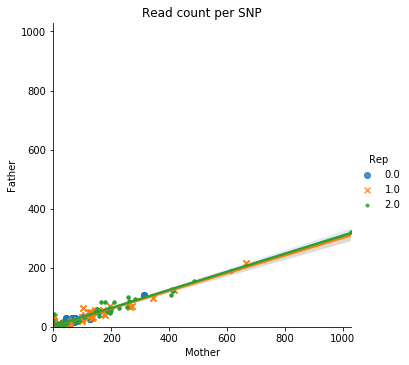

In [9]:
sns.lmplot(x='Mother',y='Father',hue='Rep',data=df_main_removeInf,markers=['o','x','.'])
ax = plt.gca()
ax.set_title("Read count per SNP")
mx = max(df_main_removeInf['Mother'].max(), df_main_removeInf['Father'].max())
ax.set_xlim(0,mx)
ax.set_ylim(0,mx)



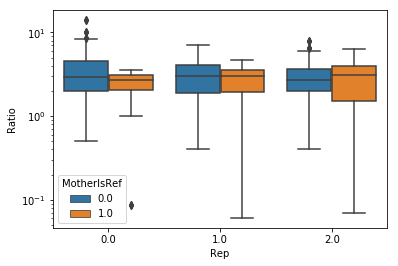

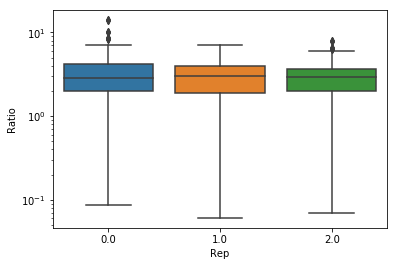

In [10]:
plt.figure()
ax = sns.boxplot(x='Rep',y='Ratio',data=df_main_removeInf,hue='MotherIsRef')
ax.set_yscale('log')


plt.figure()
ax = sns.boxplot(x='Rep',y='Ratio',data=df_main_removeInf)
ax.set_yscale('log')

In [11]:
#df_zero = df_main[(df_main['Mother']==0.0) | (df_main['Father']==0.0) ]
only_mother = df_main['Father'] == 0.0
only_father = df_main['Mother'] == 0.0

df_main['Status'] = np.where(only_mother, 'Only mother', np.where(only_father,'Only father','Both'))
df_main['Sum count'] = df_main['Mother'] + df_main['Father']
#ax = sns.boxplot(x='Rep',y='Mother',data=df_main[df_main['False'])

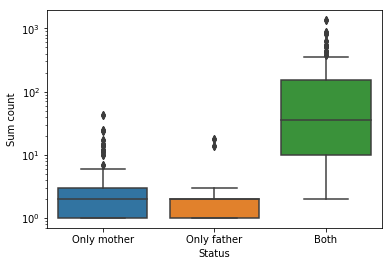

In [12]:
ax = sns.boxplot(x='Status',y='Sum count',data=df_main)
ax.set_yscale('log')


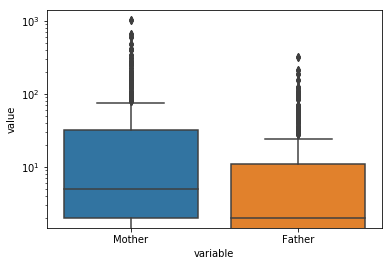

In [13]:
ax = sns.boxplot(x = 'variable', y = 'value', data=pd.melt(df_main[['Mother','Father']]))
ax.set_title("")
ax.set_yscale('log')